In [1]:
#Changing the working directory to the root
%cd ../../

c:\Users\olarinoyem\Project\Multivate-forecasting


In [2]:
import pandas as pd
import numpy as np


import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from itertools import cycle

# pio.renderers.default = "notebook_connected"
import os
from pathlib import Path
import warnings
import matplotlib.dates as mdates
import torch

warnings.filterwarnings("ignore")

In [3]:
source_data = Path("data/")
# Check if a GPU is available
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# data = pd.read_csv("data/hos_data/merged_data.csv")
data = pd.read_csv("data/old_data/merged_data.csv")
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,Vax_index,dailyCases,cumulativeCases
0,2020-04-02,1494.0,26264,12135.0,2932,0.33,4097,41174
1,2020-04-03,1788.0,28828,13635.0,2564,0.33,4102,45276
2,2020-04-04,1950.0,31421,15469.0,2593,0.33,3405,48681
3,2020-04-05,2097.0,34013,16657.0,2592,0.33,3094,51775
4,2020-04-06,2264.0,36692,17154.0,2679,0.33,4407,56182


In [5]:
data["date"] = pd.to_datetime(data["date"])
data = data.drop(columns=["cumulativeCases", "cumAdmissions"])
data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases
0,2020-04-02,1494.0,12135.0,2932,0.33,4097
1,2020-04-03,1788.0,13635.0,2564,0.33,4102
2,2020-04-04,1950.0,15469.0,2593,0.33,3405
3,2020-04-05,2097.0,16657.0,2592,0.33,3094
4,2020-04-06,2264.0,17154.0,2679,0.33,4407


In [6]:
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig


def mase(actual, predicted, insample_actual):
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample


def forecast_bias(actual, predicted):
    return np.mean(predicted - actual)


def plot_forecast(
    pred_df, forecast_columns, forecast_display_names=None, save_path=None
):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2  # Using a different color palette
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual data plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].covidOccupiedMVBeds,
            mode="lines",
            marker=dict(size=6, opacity=0.5),
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds trends",
        )
    )

    # Predicted data plot
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

In [7]:
class LogTime:
    from time import time

    def __enter__(self):
        self.start_time = self.time()
        print("Starting operation...")

    def __exit__(self, type, value, traceback):
        elapsed_time = self.time() - self.start_time
        print(f"Operation completed in {elapsed_time} seconds.")


def add_lags(df, lags, column):
    added_features = []
    for lag in lags:
        lag_col_name = f"{column}_lag_{lag}"
        df[lag_col_name] = df[column].shift(lag)
        added_features.append(lag_col_name)
    # Drop rows with NaN values
    df.dropna(inplace=True)
    return df, added_features

In [8]:
# filter the features in the data with 7days moving average
# data["covidOccupiedMVBeds"] = data["covidOccupiedMVBeds"].rolling(7).mean()
# data["hospitalCases"] = data["hospitalCases"].rolling(7).mean()
# data["newAdmissions"] = data["newAdmissions"].rolling(7).mean()
# data["dailyCases"] = data["dailyCases"].rolling(7).mean()

data = data.dropna()
data = data.drop(columns=["Vax_index"])
data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases
0,2020-04-02,1494.0,12135.0,2932,4097
1,2020-04-03,1788.0,13635.0,2564,4102
2,2020-04-04,1950.0,15469.0,2593,3405
3,2020-04-05,2097.0,16657.0,2592,3094
4,2020-04-06,2264.0,17154.0,2679,4407


In [9]:
lags = [3, 7]

data_with_lags, added_features = add_lags(data, lags, "covidOccupiedMVBeds")

In [10]:
data_with_lags.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7
7,2020-04-09,2546.0,18423.0,2340,4076,2264.0,1494.0
8,2020-04-10,2820.0,18669.0,2196,3590,2472.0,1788.0
9,2020-04-11,2865.0,18604.0,1955,3085,2561.0,1950.0
10,2020-04-12,2881.0,18974.0,1791,2958,2546.0,2097.0
11,2020-04-13,2872.0,18621.0,1912,3463,2820.0,2264.0


In [11]:
# plot covidOccupiedMVBeds with lags to see how they correlate with the original data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data_with_lags.index,
        y=data_with_lags["covidOccupiedMVBeds"],
        mode="lines",
        marker=dict(size=6, opacity=0.5),
        line=dict(color="blue", width=2),
        name="Actual COVID-19 MVBeds trends",
    )
)

for lag in added_features:
    fig.add_trace(
        go.Scatter(
            x=data_with_lags.index,
            y=data_with_lags[lag],
            mode="lines+markers",
            marker=dict(size=4),
            line=dict(width=2),
            name=lag,
        )
    )

fig = format_plot(fig, title="COVID-19 MVBeds with Lags", ylabel="COVID-19 MVBeds")
fig.show()

In [12]:
def add_seasonal_rolling_features(df, rolls, seasonal_periods, columns, agg_funcs):
    added_features = []

    for column in columns:
        for roll in rolls:
            for period in seasonal_periods:
                for func in agg_funcs:
                    roll_column = f"{column}_roll_{roll}_period_{period}_{func}"

                    # Calculate the rolling feature
                    rolled = df[column].rolling(window=roll * period)
                    if func == "mean":
                        df[roll_column] = rolled.mean()
                    elif func == "std":
                        df[roll_column] = rolled.std()

                    added_features.append(roll_column)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df, added_features

In [13]:
# Define parameters for the function
rolls = [1]
seasonal_periods = [7]  # Example: 7 days for weekly, 30 days for monthly
columns = ["covidOccupiedMVBeds", "hospitalCases", "newAdmissions", "dailyCases"]
agg_funcs = ["mean"]

with LogTime():
    data, added_features = add_seasonal_rolling_features(
        data, rolls, seasonal_periods, columns, agg_funcs
    )

print(f"Features Created: {','.join(added_features)}")

Starting operation...
Operation completed in 0.002959012985229492 seconds.
Features Created: covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean


In [14]:
# correlation matrix between the rolling features and the target variable
corr_matrix = data.corr()
corr_matrix["covidOccupiedMVBeds"].sort_values(ascending=False)

# plot the correlation matrix
fig = go.Figure(
    data=go.Heatmap(z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.columns)
)
fig.update_layout(title="Correlation Matrix of Rolling Features")
fig.show()

In [15]:
data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean
13,2020-04-15,2847.0,17934.0,1608,4240,2881.0,2561.0,2811.428571,18539.571429,1951.571429,3568.571429
14,2020-04-16,2838.0,17783.0,1777,4360,2872.0,2546.0,2853.142857,18448.142857,1871.142857,3609.142857
15,2020-04-17,2780.0,16728.0,1674,4088,2849.0,2820.0,2847.428571,18170.857143,1796.571429,3680.285714
16,2020-04-18,2868.0,16850.0,1411,4142,2847.0,2865.0,2847.857143,17920.285714,1718.857143,3831.285714
17,2020-04-19,2820.0,16928.0,1475,3494,2838.0,2881.0,2839.142857,17628.000000,1673.714286,3907.857143


In [16]:
from src.feature_engineering.temporal_features import add_temporal_features

# Temporarily reset the index
data_reset = data.reset_index()

with LogTime():
    data_reset, added_features = add_temporal_features(
        data_reset,
        field_name="date",
        frequency="D",
        add_elapsed=True,
        drop=False,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

# Set the 'date' column back as the index
data = data_reset.set_index("date")
data.drop(columns=["index"], inplace=True)

Starting operation...
Operation completed in 0.005911111831665039 seconds.
Features Created: _Month,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed


In [17]:
data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean,...,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,2847.0,17934.0,1608,4240,2881.0,2561.0,2811.428571,18539.571429,1951.571429,3568.571429,...,2,0,0,0,0,0,2,2,106,1586908800
2020-04-16,2838.0,17783.0,1777,4360,2872.0,2546.0,2853.142857,18448.142857,1871.142857,3609.142857,...,2,0,0,0,0,0,3,3,107,1586995200
2020-04-17,2780.0,16728.0,1674,4088,2849.0,2820.0,2847.428571,18170.857143,1796.571429,3680.285714,...,2,0,0,0,0,0,4,4,108,1587081600
2020-04-18,2868.0,16850.0,1411,4142,2847.0,2865.0,2847.857143,17920.285714,1718.857143,3831.285714,...,2,0,0,0,0,0,5,5,109,1587168000
2020-04-19,2820.0,16928.0,1475,3494,2838.0,2881.0,2839.142857,17628.000000,1673.714286,3907.857143,...,2,0,0,0,0,0,6,6,110,1587254400


In [18]:
from src.transforms.target_transformations import AutoStationaryTransformer

# Set the target variable
target = "covidOccupiedMVBeds"

# Initialize the AutoStationaryTransformer with a seasonality period
# Adjust the seasonal_period based on your data's seasonality (for example, 7 for weekly seasonality)
seasonal_period = 7
auto_stationary = AutoStationaryTransformer(seasonal_period=seasonal_period)

# Fit and transform the target column to make it stationary
data_stat = auto_stationary.fit_transform(data[[target]], freq="D")

# Replace the original target values with the transformed stationary values
data[target] = data_stat.values

# Print the transformed data to check
data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean,...,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,57.707521,17934.0,1608,4240,2881.0,2561.0,2811.428571,18539.571429,1951.571429,3568.571429,...,2,0,0,0,0,0,2,2,106,1586908800
2020-04-16,57.634510,17783.0,1777,4360,2872.0,2546.0,2853.142857,18448.142857,1871.142857,3609.142857,...,2,0,0,0,0,0,3,3,107,1586995200
2020-04-17,57.113305,16728.0,1674,4088,2849.0,2820.0,2847.428571,18170.857143,1796.571429,3680.285714,...,2,0,0,0,0,0,4,4,108,1587081600
2020-04-18,57.923064,16850.0,1411,4142,2847.0,2865.0,2847.857143,17920.285714,1718.857143,3831.285714,...,2,0,0,0,0,0,5,5,109,1587168000
2020-04-19,57.496749,16928.0,1475,3494,2838.0,2881.0,2839.142857,17628.000000,1673.714286,3907.857143,...,2,0,0,0,0,0,6,6,110,1587254400


In [19]:
# Plot the transformed target variable
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data[target],
        mode="lines",
        marker=dict(size=6, opacity=0.5),
        line=dict(color="blue", width=2),
        name="Transformed COVID-19 MVBeds trends",
    )
)

fig = format_plot(
    fig, title="Transformed COVID-19 MVBeds", ylabel="Transformed COVID-19 MVBeds"
)
fig.show()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-04-15 to 2023-05-31
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   covidOccupiedMVBeds                       1142 non-null   float64
 1   hospitalCases                             1142 non-null   float64
 2   newAdmissions                             1142 non-null   int64  
 3   dailyCases                                1142 non-null   int64  
 4   covidOccupiedMVBeds_lag_3                 1142 non-null   float64
 5   covidOccupiedMVBeds_lag_7                 1142 non-null   float64
 6   covidOccupiedMVBeds_roll_1_period_7_mean  1142 non-null   float64
 7   hospitalCases_roll_1_period_7_mean        1142 non-null   float64
 8   newAdmissions_roll_1_period_7_mean        1142 non-null   float64
 9   dailyCases_roll_1_period_7_mean           1142 non-null   float64
 10  _Month            

In [21]:
data.columns

Index(['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'dailyCases',
       'covidOccupiedMVBeds_lag_3', 'covidOccupiedMVBeds_lag_7',
       'covidOccupiedMVBeds_roll_1_period_7_mean',
       'hospitalCases_roll_1_period_7_mean',
       'newAdmissions_roll_1_period_7_mean', 'dailyCases_roll_1_period_7_mean',
       '_Month', '_Quarter', '_Is_quarter_end', '_Is_quarter_start',
       '_Is_year_end', '_Is_year_start', '_Is_month_start', '_WeekDay',
       '_Dayofweek', '_Dayofyear', '_Elapsed'],
      dtype='object')

In [22]:
# data = data.drop(columns=["hospitalCases", "newAdmissions", "dailyCases"])

# Data from 2020 till 2021 is to be selected
# data = data.loc["2020-01-01":"2021-12-31"]

In [23]:
# Get the minimum and maximum date from the data
min_date = data.index.min()
max_date = data.index.max()

# Calculate the range of dates
date_range = max_date - min_date

# Define the end date for the training set (75% of the data) and validation set (10% of the data)
train_end = min_date + pd.Timedelta(days=date_range.days * 0.60)
val_end = train_end + pd.Timedelta(days=date_range.days * 0.20)

# Split the data into train, validation, and test sets based on the date ranges
train = data[data.index < train_end]
val = data[(data.index >= train_end) & (data.index < val_end)]
test = data[data.index >= val_end]

# Calculate the percentage of dates in each dataset
total_samples = len(data)
train_percentage = len(train) / total_samples * 100
val_percentage = len(val) / total_samples * 100
test_percentage = len(test) / total_samples * 100

print(
    f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}"
)
print(
    f"Percentage of Dates in Train: {train_percentage:.2f}% | Percentage of Dates in Validation: {val_percentage:.2f}% | Percentage of Dates in Test: {test_percentage:.2f}%"
)
print(
    f"Max Date in Train: {train.index.max()} | Min Date in Validation: {val.index.min()} | Min Date in Test: {test.index.min()}"
)

# of Training samples: 685 | # of Validation samples: 228 | # of Test samples: 229
Percentage of Dates in Train: 59.98% | Percentage of Dates in Validation: 19.96% | Percentage of Dates in Test: 20.05%
Max Date in Train: 2022-02-28 00:00:00 | Min Date in Validation: 2022-03-01 00:00:00 | Min Date in Test: 2022-10-15 00:00:00


In [24]:
train.to_csv(source_data / "model_data/targetTransf_train.csv")
val.to_csv(source_data / "model_data/targetTransf_val.csv")
test.to_csv(source_data / "model_data/targetTransf_test.csv")

In [25]:
# Concatenate the DataFrames
sample_df = pd.concat([train, val, test])

# Convert feature columns to float32
# Exclude the 'type' column from conversion as it's a string column
for col in sample_df.columns:
    if col != "type":
        sample_df[col] = sample_df[col].astype("float32")

sample_df.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,dailyCases,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean,...,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,57.707520,17934.0,1608.0,4240.0,2881.0,2561.0,2811.428467,18539.572266,1951.571411,3568.571533,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,106.0,1.586909e+09
2020-04-16,57.634510,17783.0,1777.0,4360.0,2872.0,2546.0,2853.142822,18448.142578,1871.142822,3609.142822,...,2.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,107.0,1.586995e+09
2020-04-17,57.113304,16728.0,1674.0,4088.0,2849.0,2820.0,2847.428467,18170.857422,1796.571411,3680.285645,...,2.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,108.0,1.587082e+09
2020-04-18,57.923065,16850.0,1411.0,4142.0,2847.0,2865.0,2847.857178,17920.285156,1718.857178,3831.285645,...,2.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,109.0,1.587168e+09
2020-04-19,57.496750,16928.0,1475.0,3494.0,2838.0,2881.0,2839.142822,17628.000000,1673.714233,3907.857178,...,2.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,110.0,1.587254e+09


In [26]:
# correlation matrix of the features and target variable
correlation_matrix = sample_df.corr()

# Plot the correlation matrix
fig = px.imshow(
    correlation_matrix, color_continuous_scale="RdBu", title="Correlation Matrix"
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
    titlefont={"size": 20},
    legend_title=None,
    legend=dict(
        font=dict(size=15),
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
    ),
)
fig.show()

In [27]:
sample_df.columns

Index(['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'dailyCases',
       'covidOccupiedMVBeds_lag_3', 'covidOccupiedMVBeds_lag_7',
       'covidOccupiedMVBeds_roll_1_period_7_mean',
       'hospitalCases_roll_1_period_7_mean',
       'newAdmissions_roll_1_period_7_mean', 'dailyCases_roll_1_period_7_mean',
       '_Month', '_Quarter', '_Is_quarter_end', '_Is_quarter_start',
       '_Is_year_end', '_Is_year_start', '_Is_month_start', '_WeekDay',
       '_Dayofweek', '_Dayofyear', '_Elapsed'],
      dtype='object')

In [28]:
columns_to_select = [
    "covidOccupiedMVBeds",
    # "hospitalCases",
    # "newAdmissions",
    # "dailyCases",
    "covidOccupiedMVBeds_lag_3",
    "covidOccupiedMVBeds_lag_7",
    "covidOccupiedMVBeds_roll_1_period_7_mean",
    "hospitalCases_roll_1_period_7_mean",
    "newAdmissions_roll_1_period_7_mean",
    "dailyCases_roll_1_period_7_mean",
]

In [29]:
train = train[columns_to_select]
val = val[columns_to_select]
test = test[columns_to_select]
train.head()

,covidOccupiedMVBeds,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean
date,,,,,,,
2020-04-15,57.707521,2881.0,2561.0,2811.428571,18539.571429,1951.571429,3568.571429
2020-04-16,57.634510,2872.0,2546.0,2853.142857,18448.142857,1871.142857,3609.142857
2020-04-17,57.113305,2849.0,2820.0,2847.428571,18170.857143,1796.571429,3680.285714
2020-04-18,57.923064,2847.0,2865.0,2847.857143,17920.285714,1718.857143,3831.285714
2020-04-19,57.496749,2838.0,2881.0,2839.142857,17628.000000,1673.714286,3907.857143


In [30]:
# Convert feature columns to float32 Exclude the 'type' column from conversion as it's a string column
for col in train.columns:
    if col != "type":
        train[col] = train[col].astype("float32")
        val[col] = val[col].astype("float32")
        test[col] = test[col].astype("float32")

In [31]:
cols = list(train.columns)
cols.remove("covidOccupiedMVBeds")
train = train[cols + ["covidOccupiedMVBeds"]]

In [32]:
target = "covidOccupiedMVBeds"
pred_df = pd.concat([train[[target]], val[[target]]])
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 685 entries, 2020-04-15 to 2022-02-28
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   covidOccupiedMVBeds_lag_3                 685 non-null    float32
 1   covidOccupiedMVBeds_lag_7                 685 non-null    float32
 2   covidOccupiedMVBeds_roll_1_period_7_mean  685 non-null    float32
 3   hospitalCases_roll_1_period_7_mean        685 non-null    float32
 4   newAdmissions_roll_1_period_7_mean        685 non-null    float32
 5   dailyCases_roll_1_period_7_mean           685 non-null    float32
 6   covidOccupiedMVBeds                       685 non-null    float32
dtypes: float32(7)
memory usage: 24.1 KB


In [33]:
import shutil
import random
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from src.dl.multivariate_models import (
    SingleStepRNNConfig,
    SingleStepRNNModel,
    Seq2SeqConfig,
    Seq2SeqModel,
    TransformerConfig,
    TransformerModel,
)
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from tqdm.notebook import tqdm

# For reproduceability set a random seed

torch.set_float32_matmul_precision("high")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

pl.seed_everything(42)

Seed set to 42


42

In [34]:
datamodule = TimeSeriesDataModule(
    data=train,
    n_val=val.shape[0],
    n_test=test.shape[0],
    window=7,  # 7 days window
    horizon=1,  # single step
    normalize="global",  # normalizing the data
    batch_size=32,
    num_workers=0,
)
datamodule.setup()

In [35]:
# Check a few batches from the training dataloader
train_loader = datamodule.train_dataloader()
for x, y in train_loader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    break

Input batch shape: torch.Size([32, 7, 7])
Output batch shape: torch.Size([32, 1, 1])


In [38]:
rnn_config = SingleStepRNNConfig(
    rnn_type="GRU",
    input_size=7,  # 25 for multivariate time series
    hidden_size=64,  # 64 hidden units
    num_layers=5,
    bidirectional=True,
    learning_rate=1e-3,
    # lr_scheduler_params={"step_size": 10, "gamma": 0.1}
)
model = SingleStepRNNModel(rnn_config)
model.float()

SingleStepRNNModel(
  (rnn): GRU(7, 64, num_layers=5, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (loss): MSELoss()
)

In [39]:
trainer = pl.Trainer(
    accelerator="gpu",
    # strategy='ddp_notebook',
    devices=1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10, mode="min")
    ],
)
trainer.fit(model, datamodule)
# Removing artifacts created during training
shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 326 K 
1 | fc   | Linear  | 129   
2 | loss | MSELoss | 0     
---------------------------------
326 K     Trainable params
0         Non-trainable params
326 K     Total params
1.305     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [40]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()
# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
metric_record = []

In [42]:
algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": algorithm_name,
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, test["covidOccupiedMVBeds"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({"Vanilla LSTM": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)
print(metrics)

{'Algorithm': 'GRU', 'MAE': '59.5294', 'MSE': '8929.6025', 'MASE': '533.1643', 'Forecast Bias': '59.53'}


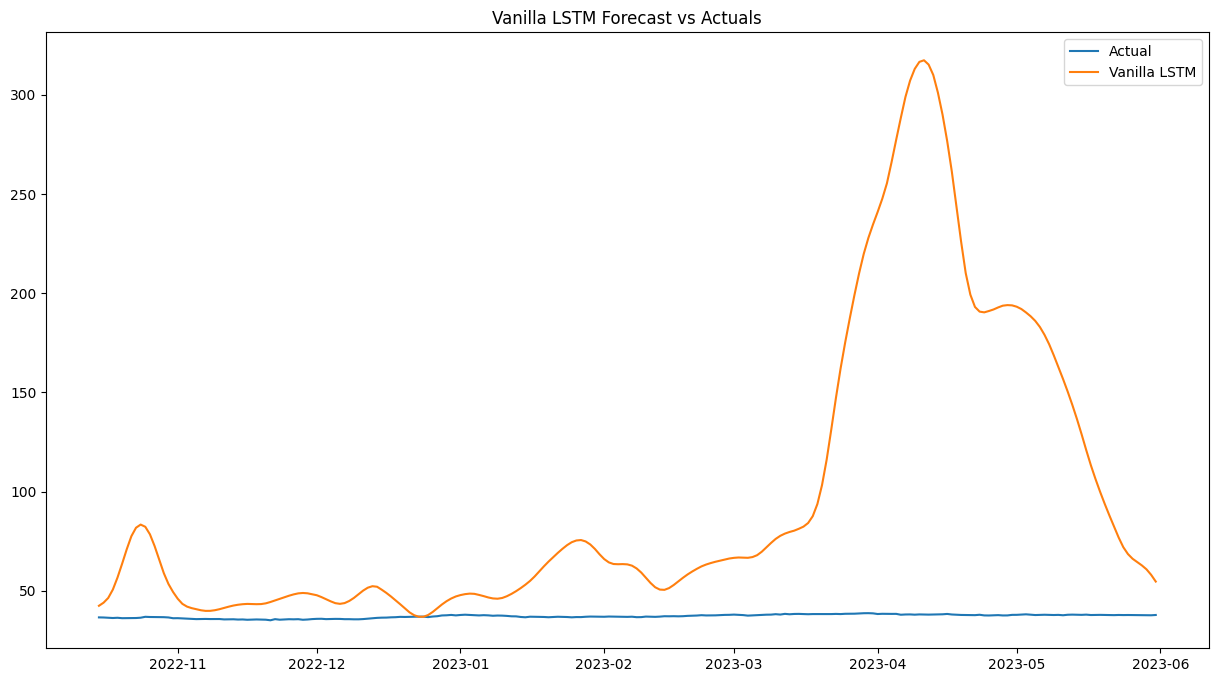

In [43]:
# code to plot the forecast with the actuals in matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(pred_df.index, pred_df["covidOccupiedMVBeds"], label="Actual")
ax.plot(pred_df.index, pred_df["Vanilla LSTM"], label="Vanilla LSTM")
ax.set_title("Vanilla LSTM Forecast vs Actuals")
ax.legend()
plt.show()

In [44]:
# Generate the forecast plot

fig = plot_forecast(
    pred_df,
    forecast_columns=["Vanilla LSTM"],
    forecast_display_names=["Vanilla LSTM"],
)

# Set the title of the plot
title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name}"
fig = format_plot(fig, title=title)

# Update the x-axis of the plot
fig.update_xaxes(
    type="date", range=["2023-01-01", "2023-04-01"], dtick="M1", tickformat="%b %Y"
)

# Show the plot
fig.show()

In [ ]:
def objective(params):
    rnn_type, hidden_size, num_layers, bidirectional, learning_rate = params
    input_size = 11

    rnn_config = SingleStepRNNConfig(
        rnn_type=rnn_type,
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        learning_rate=learning_rate,
    )
    model = SingleStepRNNModel(rnn_config)

    # Training the model using PyTorch Lightning
    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10, mode="min")
        ],
    )
    trainer.fit(model, datamodule)

    pred = trainer.predict(model, datamodule.test_dataloader())
    pred = torch.cat(pred).squeeze().detach().numpy()
    pred = pred * datamodule.train.std + datamodule.train.mean
    actuals = test[target].values

    return mae(actuals, pred)

In [ ]:
# Neighbor function to generate a new candidate solution
def neighbor(params):
    rnn_type, hidden_size, num_layers, bidirectional, learning_rate = params

    # Perturbations
    hidden_size = np.random.randint(*param_bounds["hidden_size"])
    num_layers = np.random.randint(*param_bounds["num_layers"])
    learning_rate = np.random.uniform(*param_bounds["learning_rate"])
    rnn_type = np.random.choice(param_bounds["rnn_type"])
    bidirectional = bool(
        np.random.choice(param_bounds["bidirectional"])
    )  # Convert to native boolean

    return [rnn_type, hidden_size, num_layers, bidirectional, learning_rate]


# Cooling schedule (geometric cooling)
def cooling(temp, step):
    return temp * 0.99

In [ ]:
def simulated_annealing(initial_params, initial_temp, steps):
    current_params = initial_params
    current_cost = objective(current_params)
    temp = initial_temp
    costs = [current_cost]
    temperatures = [initial_temp]

    for step in range(steps):
        new_params = neighbor(current_params)
        new_cost = objective(new_params)

        # Acceptance criterion
        if new_cost < current_cost or np.random.uniform(0, 1) < np.exp(
            (current_cost - new_cost) / temp
        ):
            current_params, current_cost = new_params, new_cost

        temp = cooling(temp, step)
        costs.append(current_cost)
        temperatures.append(temp)  # Track temperatures

    return current_params, costs, temperatures

In [ ]:
# Define the bounds for parameters
param_bounds = {
    "rnn_type": ["GRU", "LSTM", "RNN"],
    "hidden_size": (32, 256),  # Hidden size between 32 and 256
    "num_layers": (5, 100),
    "bidirectional": [True, False],
    "learning_rate": (1e-4, 1e-1),
}

# Initial hyperparameters and temperature
initial_params = ["GRU", 64, 2, True, 1e-3]  # Example initial values
initial_temp = 10
# Run Simulated Annealing
best_params, costs, temperatures = simulated_annealing(
    initial_params, initial_temp, 100
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 104 K 
1 | fc   | Linear  | 129   
2 | loss | MSELoss | 0     
---------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.417     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: input.size(-1) must be equal to input_size. Expected 11, got 10

In [ ]:
print("Best Parameters:", best_params)

Best Parameters: ['RNN', 233, 94, True, 0.03412839448947758]


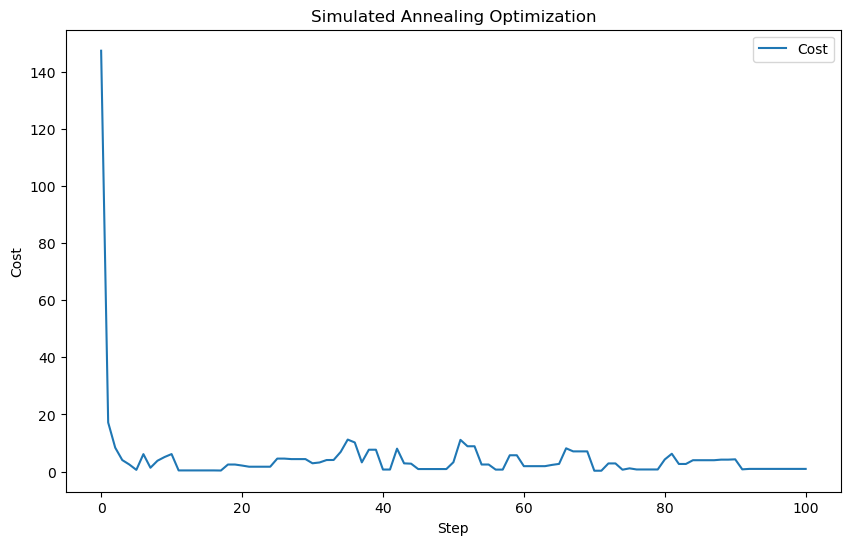

In [ ]:
# plot the loss curve of the simulated annealing algorithm for hyperparameter optimization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(costs, label="Cost")
ax.set_title("Simulated Annealing Optimization")
ax.set_xlabel("Step")
ax.set_ylabel("Cost")
ax.legend()
plt.show()

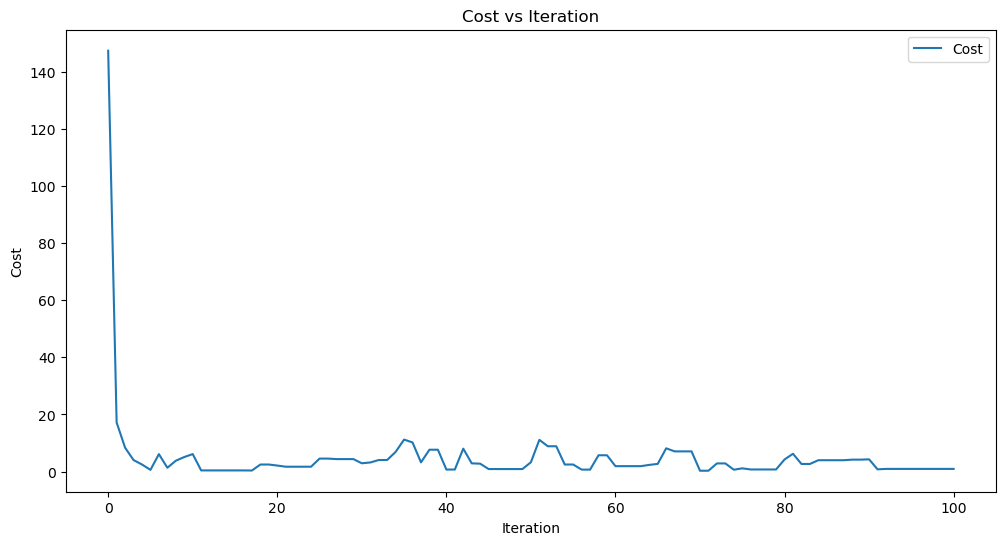

In [ ]:
# Plot the cost and temperature
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(costs, label="Cost")
ax.set_title("Cost vs Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.legend()
plt.show()

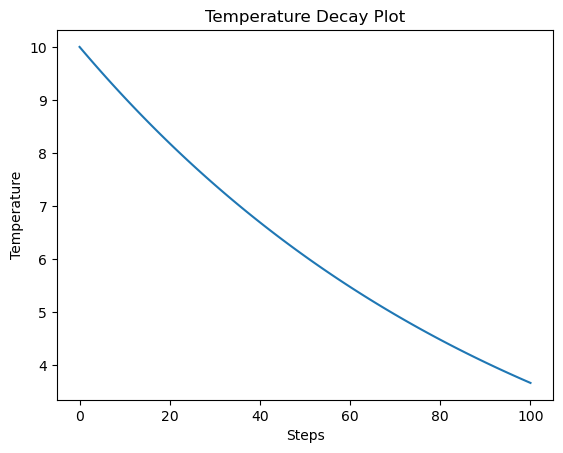

In [ ]:
plt.plot(temperatures)
plt.xlabel("Steps")
plt.ylabel("Temperature")
plt.title("Temperature Decay Plot")
plt.show()

In [ ]:
rnn_config = SingleStepRNNConfig(
    rnn_type="RNN",
    input_size=11,  # 25 for multivariate time series
    hidden_size=233,  # 64 hidden units
    num_layers=94,
    bidirectional=True,
    learning_rate=0.03412839448947758,
    lr_scheduler_params={"step_size": 10, "gamma": 0.1},
)
model = SingleStepRNNModel(rnn_config)
model.float()
# ['RNN', 233, 94, True, 0.03412839448947758]

SingleStepRNNModel(
  (rnn): RNN(11, 233, num_layers=94, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=466, out_features=1, bias=True)
  (loss): MSELoss()
)

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    # strategy='ddp_notebook',
    devices=1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid_loss", patience=15, mode="min")
    ],
)
trainer.fit(model, datamodule)
# Removing artifacts created during training
shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 30.5 M
1 | fc   | Linear  | 467   
2 | loss | MSELoss | 0     
---------------------------------
30.5 M    Trainable params
0         Non-trainable params
30.5 M    Total params
121.980   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()
# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": algorithm_name,
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, test["covidOccupiedMVBeds_lag_7"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({"Vanilla LSTM": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)
print(metrics)

{'Algorithm': 'RNN', 'MAE': '11.9898', 'MSE': '143.8841', 'MASE': '4.6827', 'Forecast Bias': '-11.99'}


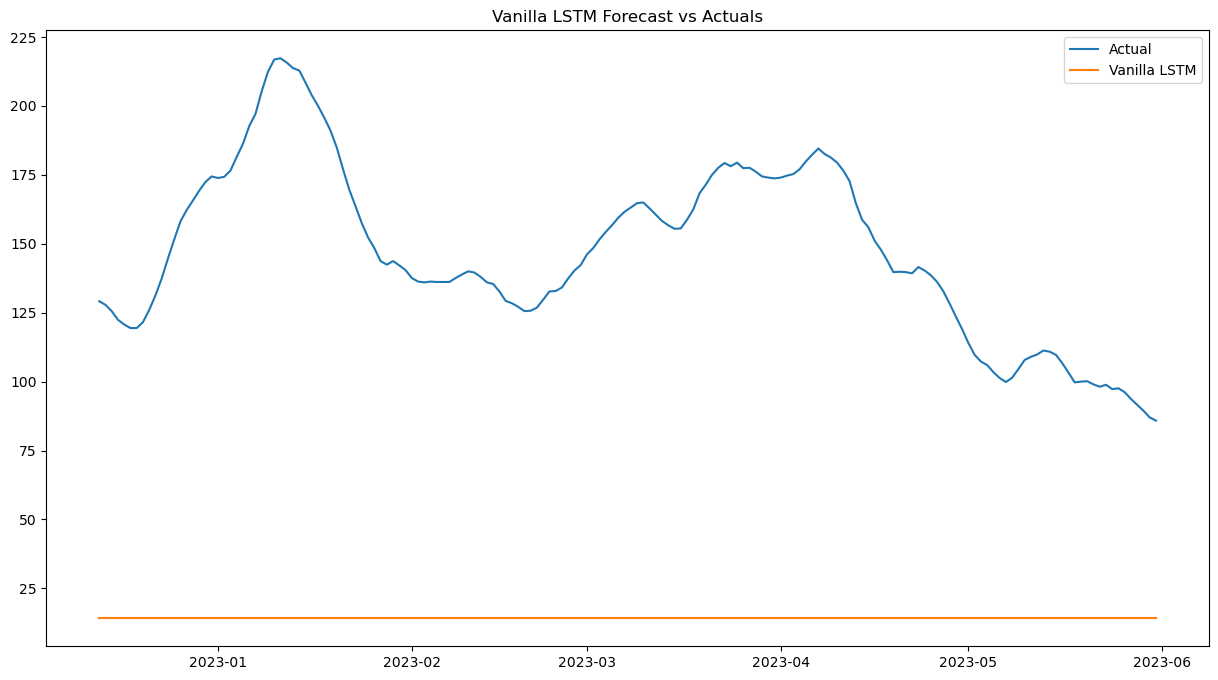

In [ ]:
# plot the forecast with the actuals in matplotlib
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(pred_df.index, pred_df["covidOccupiedMVBeds_lag_7"], label="Actual")
ax.plot(pred_df.index, pred_df["Vanilla LSTM"], label="Vanilla LSTM")
ax.set_title("Vanilla LSTM Forecast vs Actuals")
ax.legend()
plt.show()

In [ ]:
# Generate the forecast plot

fig = plot_forecast(
    pred_df,
    forecast_columns=["Vanilla LSTM"],
    forecast_display_names=["Vanilla LSTM"],
)

# Set the title of the plot
title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name}"
fig = format_plot(fig, title=title)

# Update the x-axis of the plot
fig.update_xaxes(
    type="date", range=["2023-01-01", "2023-04-01"], dtick="M1", tickformat="%b %Y"
)

# Show the plot
fig.show()

In [ ]:
# Define the Seq2Seq Model Configuration
seq2seq_config = Seq2SeqConfig(
    encoder_type="GRU",
    decoder_type="GRU",
    encoder_params={
        "input_size": 11,  # Adjust as per your feature dimensions
        "hidden_size": 128,
        "num_layers": 2,  # You can adjust the number of layers
        "bidirectional": True,
    },
    decoder_params={
        "output_size": 1,  # Adjust based on your model's needs
        "hidden_size": 128,
        "num_layers": 5,  # You can adjust the number of layers
        "bidirectional": True,
        "attention": {"use": True, "method": "dot"},
    },
    decoder_use_all_hidden=False,
    teacher_forcing_ratio=0.5,  # Adjust based on your model's needs
    learning_rate=1e-3,
)

# Initialize the Seq2Seq Model with the Configuration
model = Seq2SeqModel(seq2seq_config)
model.float()

TypeError: RNNBase.__init__() got an unexpected keyword argument 'output_size'

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid_loss", patience=15, mode="min")
    ],
)

# Fit the model
trainer.fit(model, datamodule)

shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | GRU     | 404 K 
1 | decoder | GRU     | 601 K 
2 | fc      | Linear  | 257   
3 | loss    | MSELoss | 0     
------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.025     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: input.size(-1) must be equal to input_size. Expected 267, got 11